### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

In [2]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 
    image_transforms = transforms.Compose([
      transforms.Resize((128,128)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])# TODO
    label_transforms = transforms.Compose([
      transforms.Resize((128,128)),
      ToIntTensor()
    ])# TODO

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "/Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [3]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    criterion = nn.CrossEntropyLoss(ignore_index=255)  # recommend to use in constructing loss

    # TODO: Train (3 points)
    # Iterate over the train dataloader
    # Put data batch on same device as model
    # "Forward pass" - run data through model, and use output to calculate loss. 
    # "backward pass"
    # Remember to keep track of training loss during loop. 
        
    # TODO: Validation loss and accuracy (2 points)
    # estimate the loss on the validation dataset
    # The network should be in "eval" mode (remember to go back to train mode for training)
    # Turn off grad tracking for speed 
    # Accuracy on validation datais very helpful to output - 
    # 69 percent of pixels are "background" - we hope to get better accuracy than that!
    
    model.train()  # Set the model to train mode
    train_loss = 0.0

    # Training loop
    for images, targets in train_dl:
        images = images.to(device)
        targets = targets.to(device)  # Remove the extra dimension

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)["out"]  # Access the "out" key from the model output dictionary
        targets = targets.squeeze(1)  

        # Calculate the loss
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate average training loss\
    train_loss /= len(train_dl)

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    # Validation loop
    with torch.no_grad():
        for images, targets in val_dl:
            images = images.to(device)
            targets = targets.to(device)  

            # Forward pass
            outputs = model(images)["out"]  # Access the "out" key from the model output dictionary
            targets = targets.squeeze(1)


            # Calculate the loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted_label = outputs.argmax(dim=1)  # batch, h, w, integer 0...20 
            accuracy = (predicted_label == targets).sum().item()
            correct += accuracy
            total += targets.numel()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_dl)
    accuracy = 100. * correct / total

    # Switch back to train mode
    model.train()
    
    return train_loss, val_loss, accuracy 

### Main loop

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.001
# dropout_rate = 0.65  # Dropout rate
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Add dropout to the model
# model.dropout = nn.Dropout(p=dropout_rate)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Using downloaded and verified file: /Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/VOCtrainval_06-Nov-2007.tar
Extracting /Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/VOCtrainval_06-Nov-2007.tar to /Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/
Using downloaded and verified file: /Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/VOCtrainval_06-Nov-2007.tar
Extracting /Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/VOCtrainval_06-Nov-2007.tar to /Users/bablu/Desktop/UCR Courses/Spring 2023/CS229 Machine Learning/Assignments/HW_2_vision/
Epoch 1: Train loss: 2.925 | Val loss: 3.123 | Acc: 4.699
Epoch 2: Train loss: 2.342 | Val loss: 3.037 | Acc: 20.829
Epoch 3: Train loss: 1.629 | Val loss: 2.526 | Acc: 46.941
Epoch 4: Train loss: 1.140 | Val loss: 1.638 | Acc: 69.387

## Post training visualization and analysis

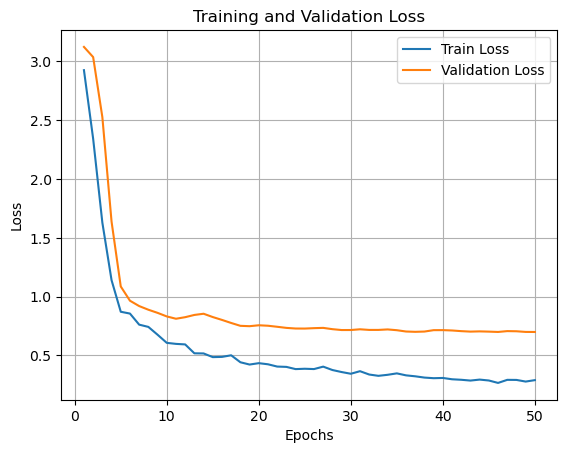

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


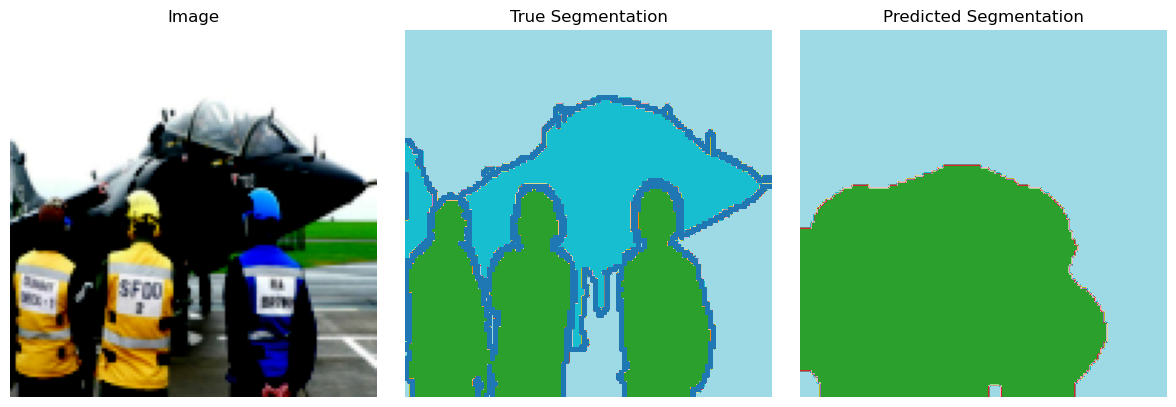

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


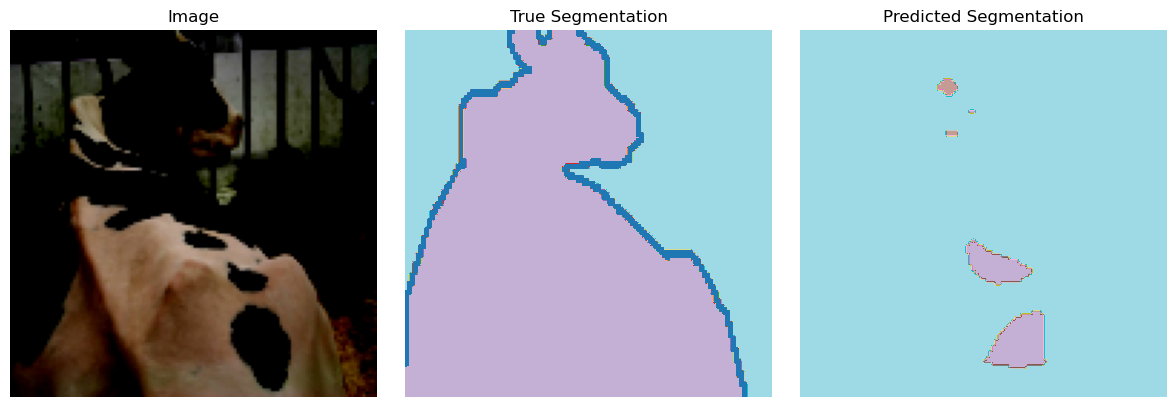

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


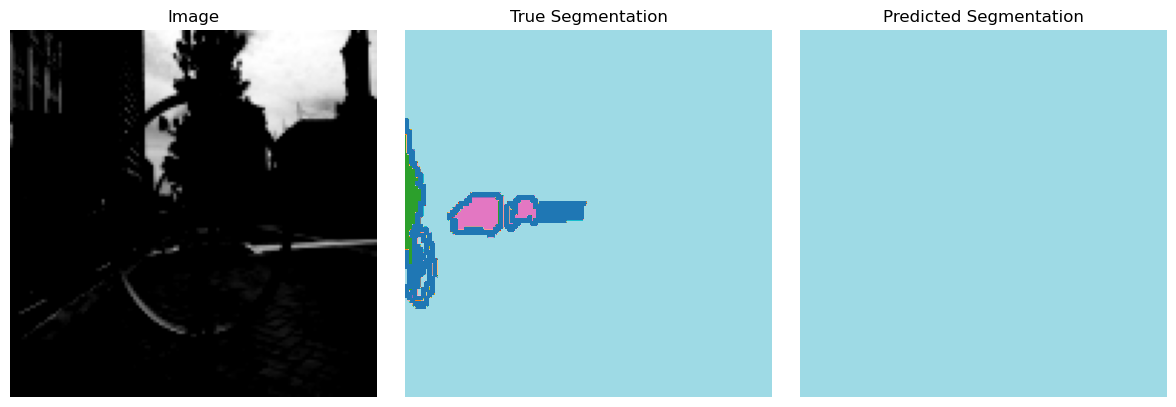

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


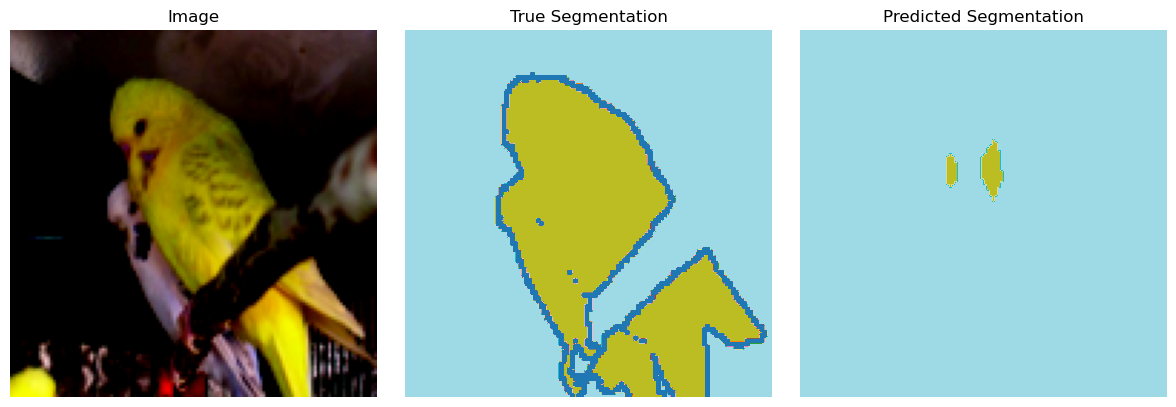

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


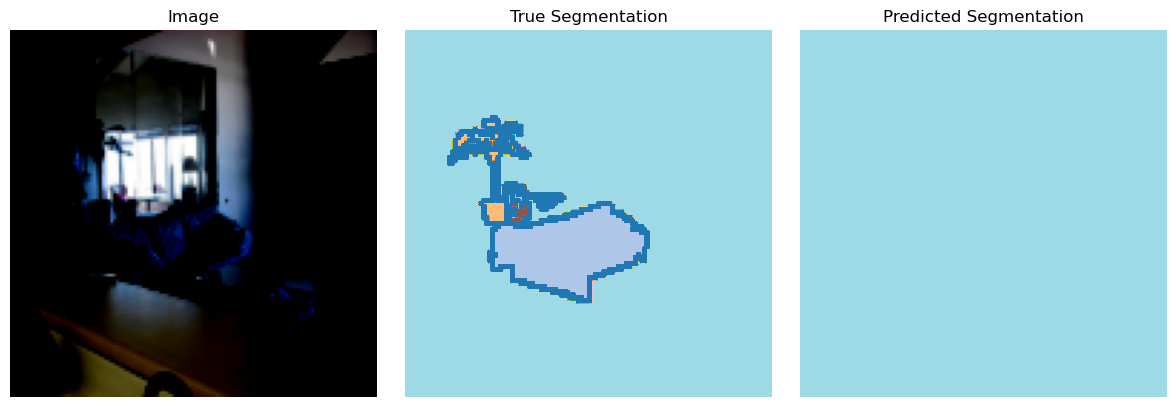

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


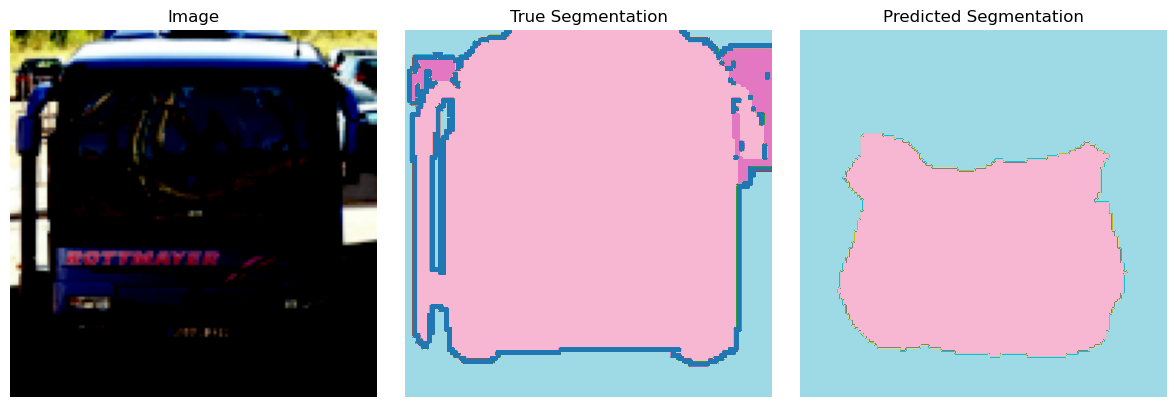

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


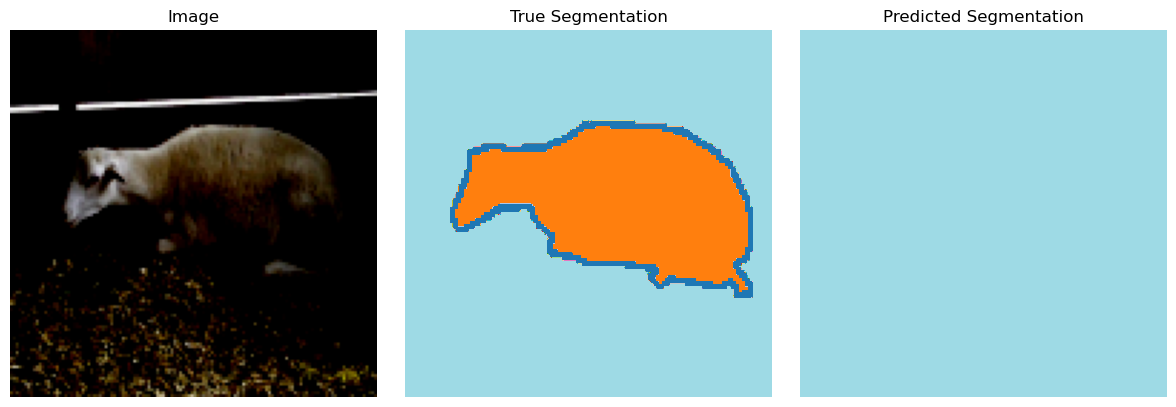

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


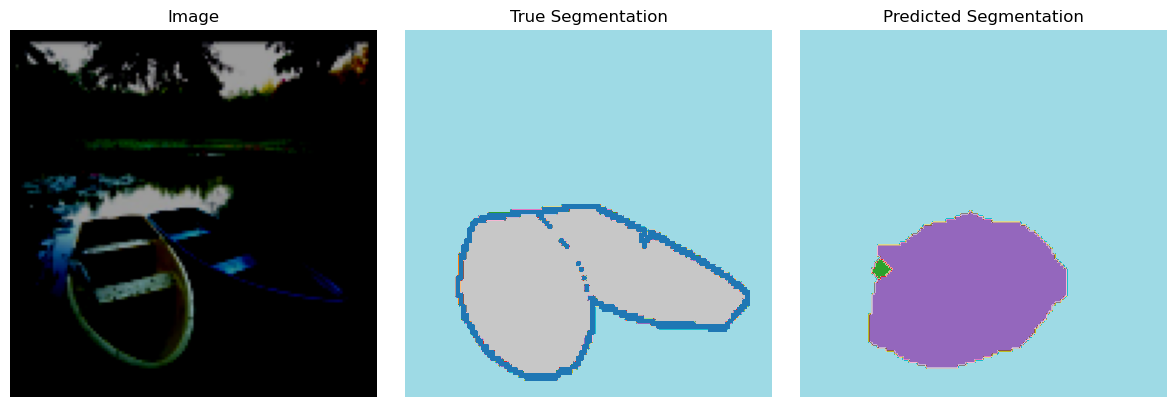

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


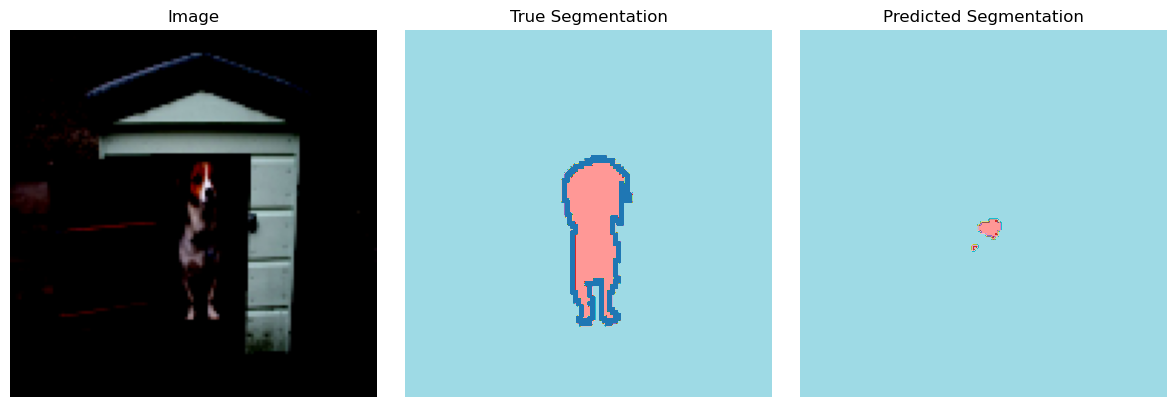

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


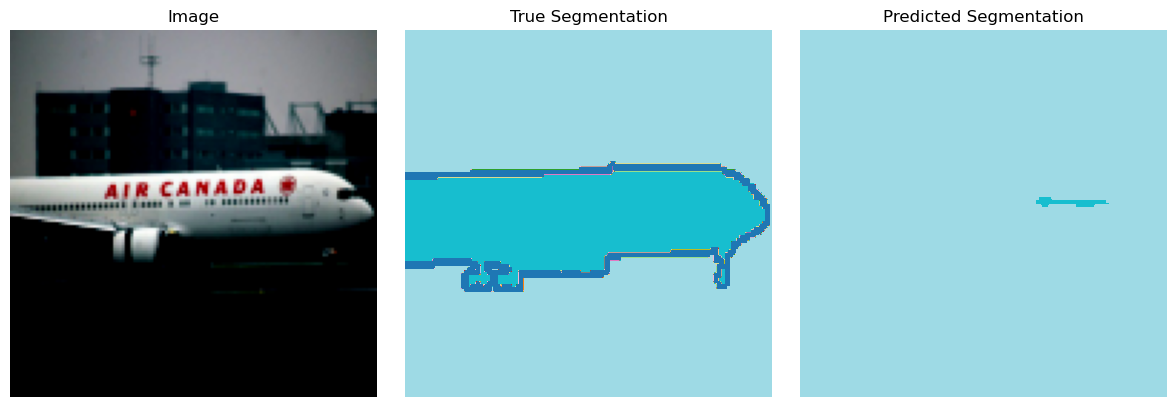

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


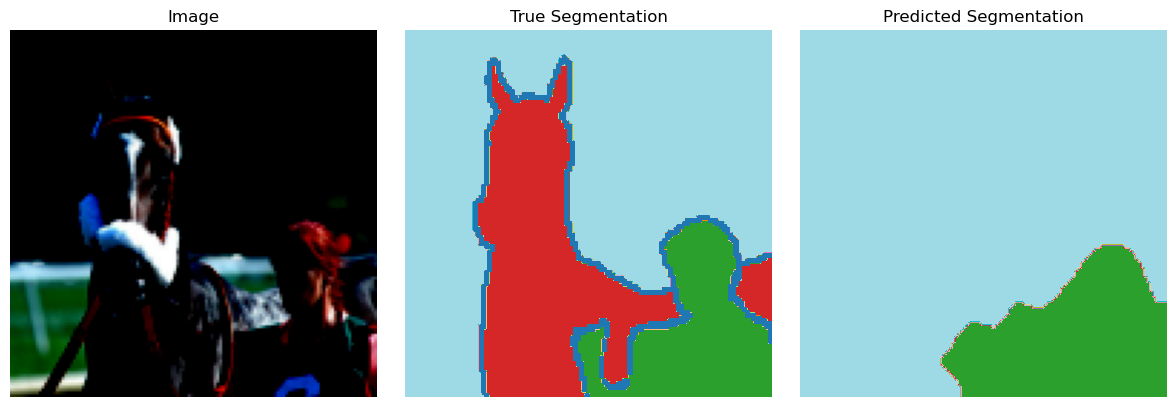

In [5]:
# TODO: Train and test loss plot
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors
def plot_loss(train_loss_history, val_loss_history):
    """
    Plot the training and validation loss over epochs.
    """
    epochs = range(1, len(train_loss_history) + 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.legend()
    plt.show()

def visualize_segmentation(image, true_seg, pred_seg, cmap):
    """
    Visualize an example image with the true segmentation and predicted segmentation.
    """
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Permute image dimensions if necessary
    if image.shape[0] == 3 and image.shape[2] == 128:
        image = image.permute(1, 2, 0)
    
    true_seg = true_seg.squeeze()  # Remove singleton dimension if present

    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(true_seg, cmap=cmap, vmin=0, vmax=len(cmap.colors) - 1)
    ax[1].set_title('True Segmentation')
    ax[1].axis('off')

    ax[2].imshow(pred_seg, cmap=cmap, vmin=0, vmax=len(cmap.colors) - 1)
    ax[2].set_title('Predicted Segmentation')
    ax[2].axis('off')

    fig.tight_layout()
    plt.show()

# Plot the train and validation loss
plot_loss(train_losses, val_losses)

# set the model to evaluation mode
model.eval()

# get an image and its ground truth segmentation from the validation set
images, labels = next(iter(val_dl))

# move the data to the device
images = images.to(device)

# get the predicted segmentation for the images
outputs = model(images)['out']

# convert the predicted output and the ground truth label to numpy arrays
outputs = outputs.cpu().argmax(dim=1).detach().numpy()
images = images.cpu()

# select random example indices from the batch
example_indices = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]  # Modify this to select the desired indices

# Assuming you have defined the colormap for visualizing the segmentation classes
cmap = matplotlib.colormaps.get_cmap('tab20_r')

# Plot multiple example images with their true and predicted segmentations
for example_index in example_indices:
    image = images[example_index]
    true_seg = labels[example_index]
    pred_seg = outputs[example_index]
    
    # Visualize the example image with the true and predicted segmentation
    visualize_segmentation(image, true_seg, pred_seg, cmap)


In [6]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

ECE: 0.0595


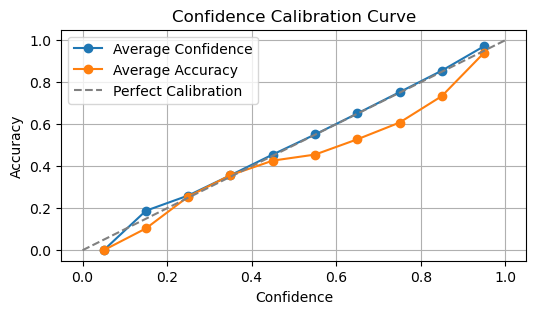

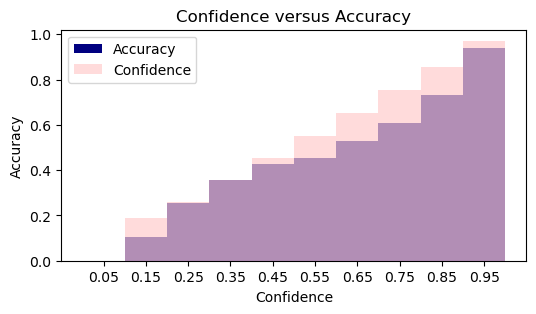

In [7]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point), using 
# TODO
# Calculate Expected Calibration Error (ECE)
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf))
print("ECE: %.4f" % ece)

# Plot confidence calibration curve
plt.figure(figsize=(6, 3))
plt.plot(bin_centers, bin_conf, marker='o', label='Average Confidence')
plt.plot(bin_centers, bin_acc, marker='o', label='Average Accuracy')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# TODO: confidence versus accuracy bar chart
plt.figure(figsize=(6, 3), facecolor='white')
width = 0.1

# Set the bar colors
# accuracy_color = (0.4, 0.6, 0.8)  # Light blue
accuracy_color = (0., 0., 0.5)
confidence_color = (1.0, 0.8, 0.8)  # Light red color
# confidence_color = (0.8, 0.8, 0.8)  # Light gray

# Plot the bars
plt.bar(bin_centers, bin_acc, width=width, label='Accuracy', color=accuracy_color)
plt.bar(bin_centers, bin_conf, width=width, label='Confidence', color=confidence_color, alpha=0.7)

# Adjust spacing between bars
plt.xticks(bin_centers)
plt.xlim(bin_centers[0] - width, bin_centers[-1] + width)

plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence versus Accuracy')
plt.legend()

plt.show()